### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSBBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12930
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1368.2| 39.6372|-119.7094|       TMAX|USC00267691|     7|[80 4D 90 55 80 5...|2010.0|SSSBSBBB|
|   1368.2| 39.6372|-119.7094|       TMIN|USC00267691|    10|[A0 D3 80 D4 90 D...|2010.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|    32|[80 54 30 55 90 5...|1893.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|     0|[40 56 90 55 80 5...|1896.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|     4|[30 55 90 55 30 5...|1897.0|SSSBSBBB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT count(distinct station) FROM weather"
print Query
df1 = sqlContext.sql(Query)
df1.show()

SELECT count(distinct station) FROM weather
+-----------------------+
|count(DISTINCT station)|
+-----------------------+
|                    154|
+-----------------------+



In [3]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather \n\tWHERE measurement='%s'"%('PRCP')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(10)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
print type(rows[1])
res_mat = numpy.zeros(shape=(365,))
#print res_mat
for i in rows:
    #print i.shape
    res_mat=np.nansum([res_mat,i],axis=0)
print res_mat
#T=np.vstack(rows)
T=np.vstack(res_mat)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)


SELECT * FROM weather 
	WHERE measurement='PRCP'
2808 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1368.2| 39.6372|-119.7094|       PRCP|USC00267691|     0|[00 00 00 00 00 0...|2010.0|SSSBSBBB|
|   2194.0| 39.3167|-120.3333|       PRCP|USW00023226|     0|[38 58 00 4D 00 0...|1949.0|SSSBSBBB|
|   2194.0| 39.3167|-120.3333|       PRCP|USW00023226|     0|[00 00 38 5B 00 4...|1950.0|SSSBSBBB|
|   2194.0| 39.3167|-120.3333|       PRCP|USW00023226|    48|[00 00 00 00 80 4...|1951.0|SSSBSBBB|
|   1324.1|   39.15|-119.1833|       PRCP|USC00268820|     0|[00 00 00 00 00 0...|1893.0|SSSBSBBB|
|   1324.1|   39.15|-119.1833|       PRCP|USC00268820|     0|[00 00 00 00 00 0...|1904.0|SSSBSBBB|
|   1324.1|   39.15|-119.1833|       PRCP|USC00268

(365, 1)

### Script for plotting yearly plots

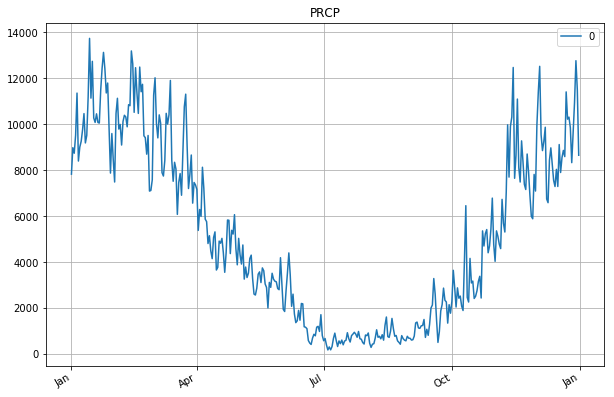

In [4]:
#print T.shape
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
#YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP_combined for all stations')
YP.plot(T[:,:],fig,ax,title='PRCP')
#title('A sample of graphs');

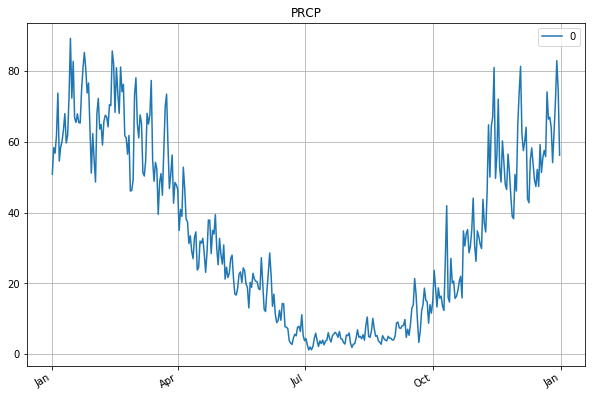

In [5]:
#Now getting AVG per stations
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
T1=T/154  # scaling to make the temperature be in centingrates
YP.plot(T1[:,:],fig,ax,title='PRCP')

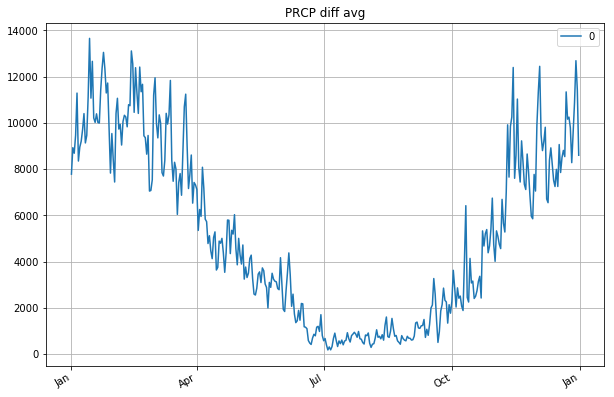

In [6]:
diff_avg=T-T1
#print diff_avg
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(diff_avg[:,:],fig,ax,title='PRCP diff avg')

In [47]:
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMIN','USC00267691')
print Query
df1 = sqlContext.sql(Query)
df1.show()
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
#print rows
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMIN' and station='USC00267691'
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1368.2| 39.6372|-119.7094|       TMIN|USC00267691|    10|[A0 D3 80 D4 90 D...|2010.0|SSSBSBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+



(1, 365)

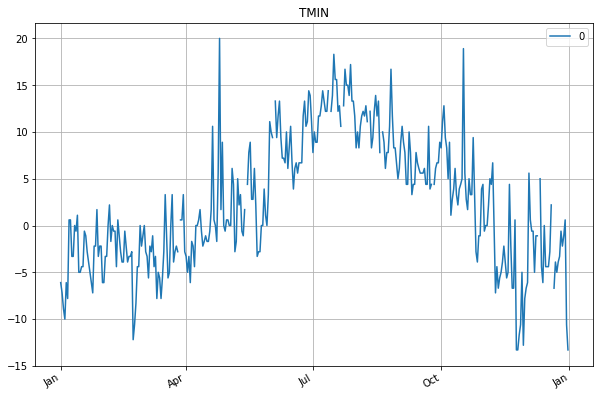

In [48]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='TMIN')

In [8]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00267691')
print Query
df1 = sqlContext.sql(Query)
df1.show()
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
#print rows
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)
Query1="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00268820')
print Query1
df2 = sqlContext.sql(Query1)
df2.show()
rows=df2.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
#print rows
T1=np.vstack(rows)
T1=T1/10.  # scaling to make the temperature be in centingrates
shape(T1)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00267691'
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1368.2| 39.6372|-119.7094|       PRCP|USC00267691|     0|[00 00 00 00 00 0...|2010.0|SSSBSBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00268820'
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1324.1|   39.15|-119.1833|       PRCP|USC00268820|     

(6, 365)

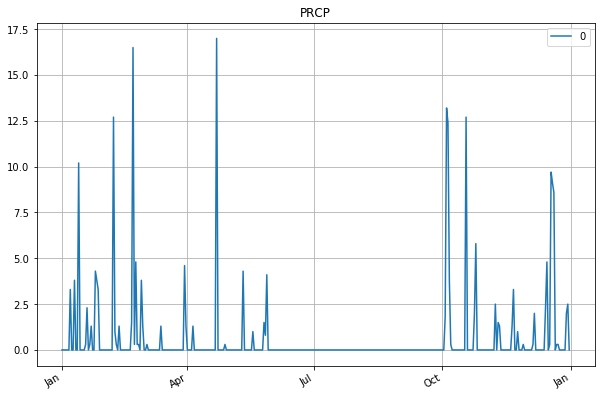

In [9]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')

#title('A sample of graphs');

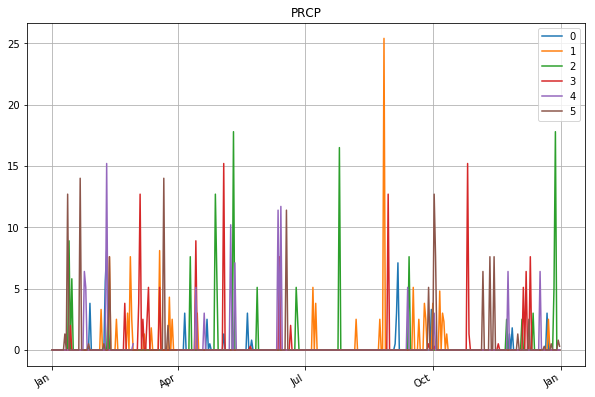

In [10]:
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T1[:,:].transpose(),fig,ax,title='PRCP')

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [42]:
STAT['PRCP']['eigvec'].shape

(365, 365)

In [11]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

In [88]:
def plot_valid_mean(m,fig,axis):
    valid_m=STAT[m]['Mean']
    YP.plot(valid_m/26,fig,axis,title='Mean daily '+m)

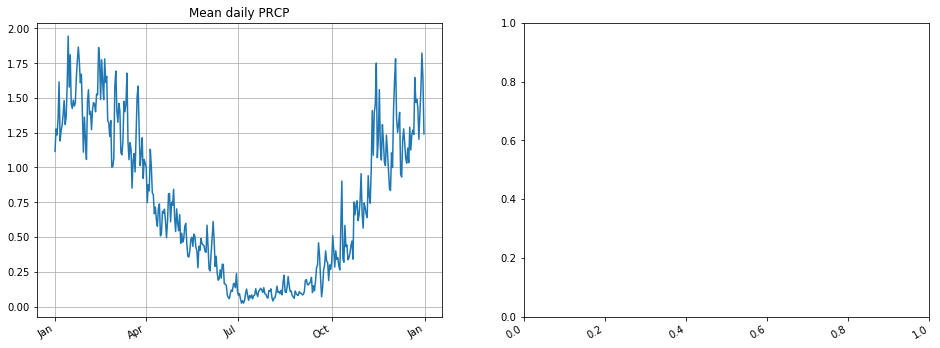

In [89]:
plot_pair(['PRCP'],plot_valid_mean)

/Disha/Anaconda/anaconda/envs/py27_1/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


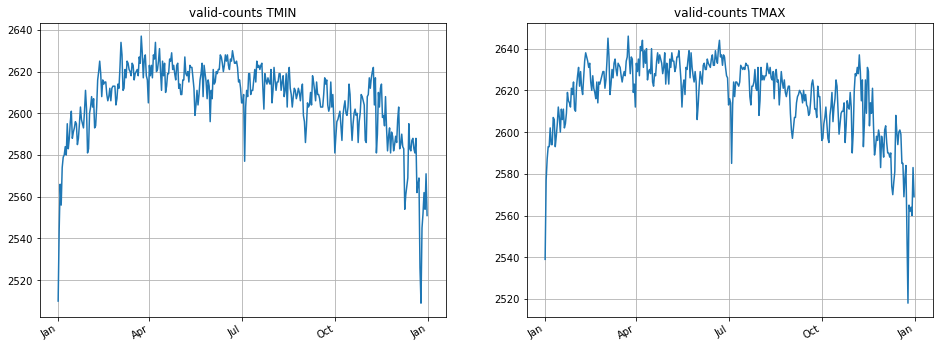

In [12]:
plot_pair(['TMIN','TMAX'],plot_valid)

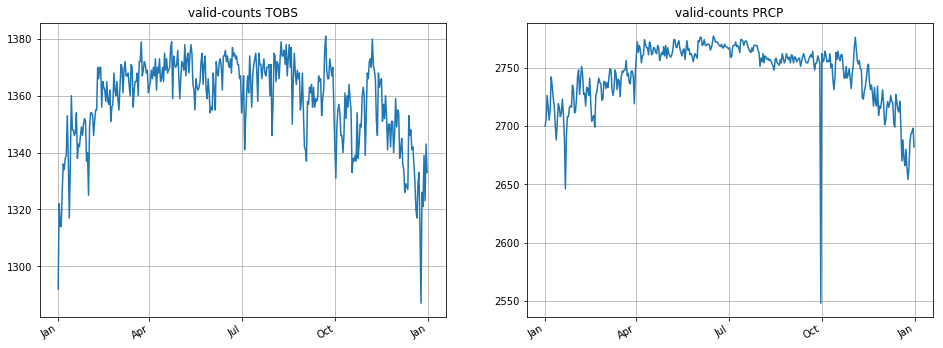

In [13]:
plot_pair(['TOBS','PRCP'],plot_valid)

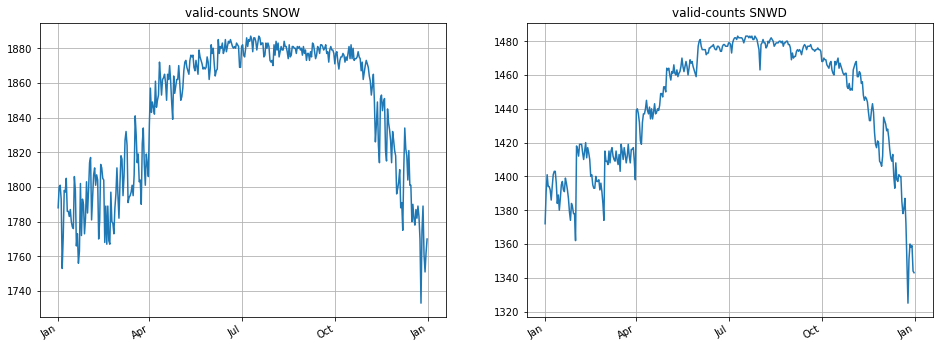

In [14]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [75]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

In [ ]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot((graphs/10*1.8)+32,fig,axis,labels=['mean-std','mean','mean+std'],title='(Degree Fahrenheit) Mean+-std   '+m)

In [45]:
STAT['TMIN']['std']

77.061077791021759

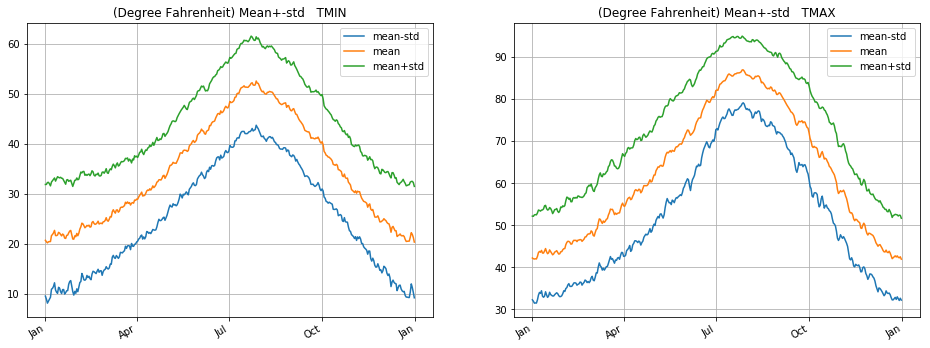

In [74]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

In [17]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

In [18]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [19]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

In [20]:
plot_pair(['TMIN','TMAX'],plot_eigen)

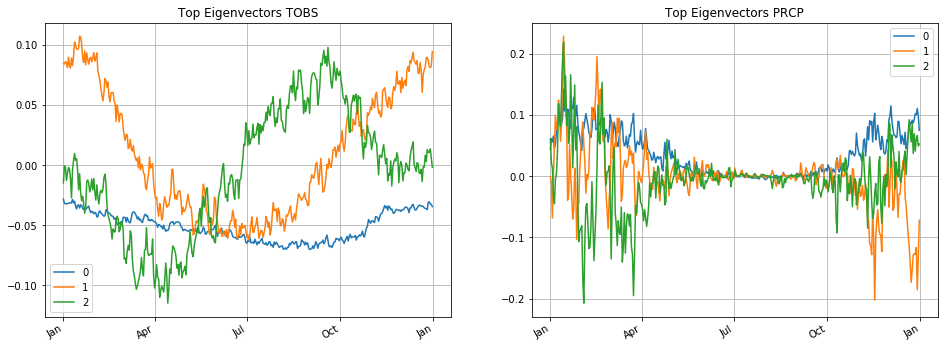

In [21]:
plot_pair(['TOBS','PRCP'],plot_eigen)

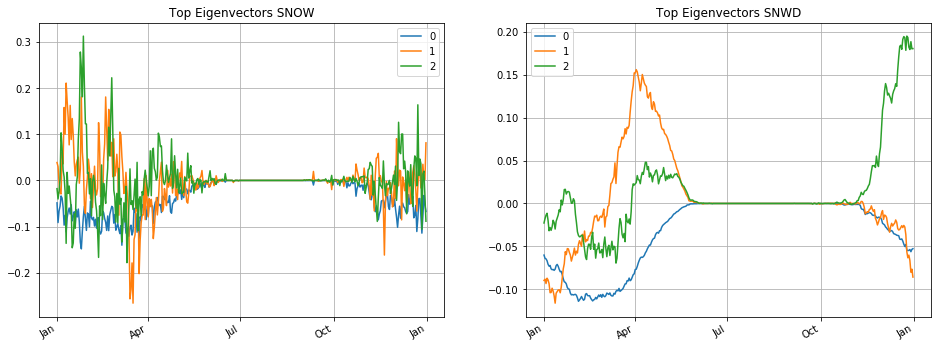

In [22]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [118]:
def pltVarExplained(j):
    subplot(2,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

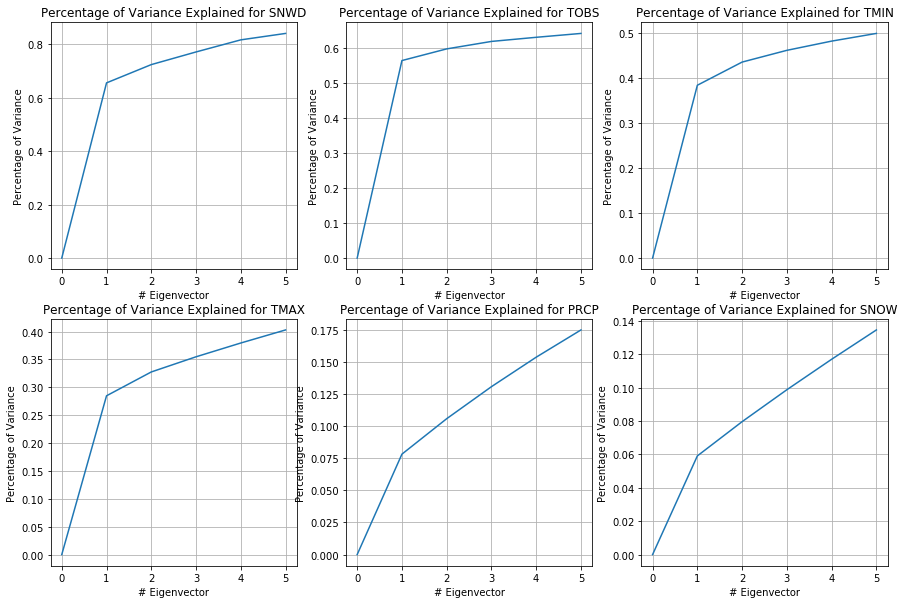

In [119]:
f=plt.figure(figsize=(15,10))
j=1
for m in ['SNWD', 'TOBS', 'TMIN','TMAX','PRCP','SNOW']: #,
    pltVarExplained(j)
    j+=1

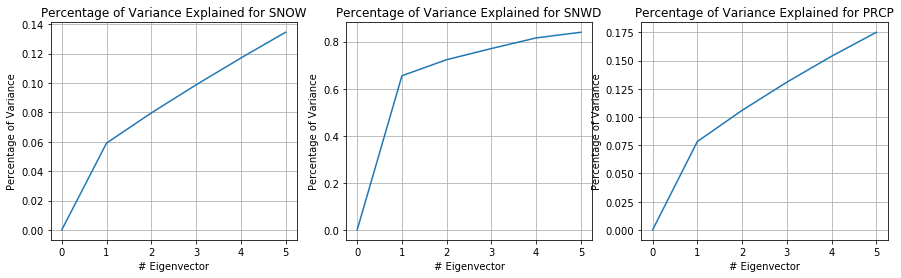

In [91]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [26]:
#sc.stop()

In [84]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs/25.7,fig,axis,labels=['mean-std','mean','mean+std'],title='(Inches) Mean+-std   '+m)

In [85]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

In [138]:
def pltVarExplained(j):
    subplot(2,3,j)
    EV=STAT[m]['eigval']
    k=7
    plot(([0,]+list(cumsum(EV[:7])))/sum(EV),color='r')
    plot(([0,]+list(cumsum(EV[:5])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

In [139]:
f=plt.figure(figsize=(15,10))
j=1
for m in ['SNWD', 'TOBS', 'TMIN','TMAX','PRCP','SNOW']: #,
    pltVarExplained(j)
    j+=1